# Color nonlinearities

The idea is to generate a gradient of colors which are linearly spaced in the ATD color spaces (oponent color channels) and then check if the response of a model is linear or not (it shouldn't be).

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import get_file

import perceptnet
from perceptualtests.color_matrices import *

## Generating the colors

In [2]:
N = 11
img_size = (256,256)

In [3]:
atd = np.array([[10,a,0] for a in np.linspace(-5,5,N)]).T
atd.shape

(3, 11)

In [4]:
def atd2rgb(atd):
    """
    Expects and atd color column vector.
    """
    rgb = Mxyz2ng@Matd2xyz@atd
    rgb = np.power(rgb, gamma[:,None])
    return rgb

In [5]:
rgb = atd2rgb(atd)
rgb.shape

(3, 11)

In [6]:
imgs = np.ones(shape=(*img_size,3,N))
imgs *= rgb[None,None,:,:]

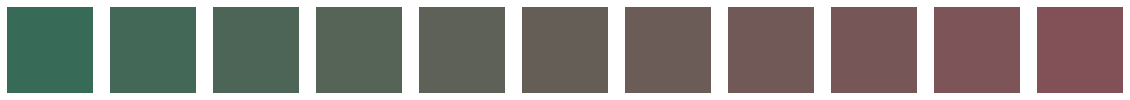

In [7]:
fig, ax = plt.subplots(1,N, figsize=(20,10))

for i in range(N):
    ax[i].imshow(imgs[:,:,:,i])
    ax[i].axis('off')
plt.show()

## Passing the colors through the network

As an example we'll use a fake model that we can override at any time:

In [8]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [9]:
model = perceptnet.networks.PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

2022-04-27 15:45:34.648976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


Adjust the shape of `imgs`:

In [10]:
batch_imgs = imgs.transpose(3,0,1,2)
batch_imgs.shape

(11, 256, 256, 3)

Obtain the outputs:

In [11]:
## Should we normalize the images...¿?¿?
batch_imgs = (batch_imgs-batch_imgs.min())/(batch_imgs.max()-batch_imgs.min())

In [12]:
outputs = model.predict(batch_imgs)

2022-04-27 15:45:39.355256: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-27 15:45:40.522728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-04-27 15:45:41.210559: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Get the readouts as the distance to the central image (white):

In [13]:
readouts = (outputs-outputs[N//2])**2
readouts = np.sqrt(np.sum(readouts.reshape(N,-1), axis=-1))
readouts

array([28.422312 , 19.453104 , 13.117049 ,  8.120783 ,  3.924501 ,
        0.       ,  3.7459989,  6.6881356,  8.891536 , 10.358241 ,
       11.173646 ], dtype=float32)

Plot the results:

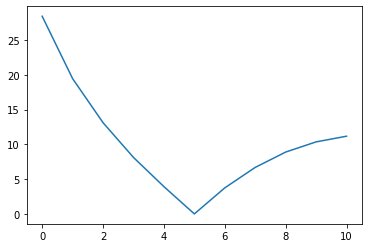

In [14]:
plt.figure()
plt.plot(readouts)
plt.show()